In [10]:
import pandas as pd

transactions_df = pd.read_csv('clean_transactions.csv')
reviews_df = pd.read_csv('clean_reviews.csv')
rfm = pd.read_csv('clustered_rfm.csv')

In [11]:
print(transactions_df['transactiondate'].max())
print(transactions_df['transactiondate'].min())

2025-01-15
2023-01-16


In [12]:
# avg revenue per customer per month
transactions_df['transactiondate'] = pd.to_datetime(transactions_df['transactiondate'], errors='coerce')
transactions_df['month'] = transactions_df['transactiondate'].dt.to_period('M')
revenue_per_month = transactions_df.groupby(['clientid', 'month'])['total'].sum().reset_index()
avg_revenue_per_month = revenue_per_month.groupby('clientid')['total'].mean().reset_index()
avg_revenue_per_month.rename(columns={'total': 'avg_revenue_per_month'}, inplace=True)
transactions_df = transactions_df.merge(avg_revenue_per_month, on='clientid', how='left')

# total revenue in the next 6 months
rfm['future_revenue'] = transactions_df['avg_revenue_per_month'] * 6

In [13]:
rfm['future_revenue'].unique()

array([ 2851.4       ,  4825.88      ,  3872.72666667,  5240.86363636,
        7601.05333333,  8104.455     ,  6354.44571429,  5642.88      ,
        7111.866     ,  2465.37      ,  5826.03333333,  7540.97142857,
        6140.31333333,  7669.968     ,  4097.2725    ,  6040.62      ,
        6398.655     ,  4296.61333333,  3940.752     ,  8953.26      ,
        9695.43      ,  5010.33      ,  8948.19      ,  5839.55142857,
        4010.01      ,  4485.6       ,  4826.15333333,  4873.38      ,
        7873.74      ,  2009.13      ,  7353.6225    ,  4630.36      ,
        4182.84      ,  7153.044     ,  5522.21      ,  5674.14      ,
        2069.64      ,  6991.11428571,  5118.27      ,  7017.276     ,
        2833.22      ,  4782.02      ,  3775.485     ,  5536.08      ,
        3589.        ,  7456.98      ,  4254.85714286,  4226.43      ,
        3028.95      ,  4252.26      ,  8873.736     ,  4341.726     ,
        8062.34      ,  4704.675     ,  9020.94      ,  4016.55      ,
      

In [14]:
rfm.head()

,clientid,recency,frequency,monetaryvalue,avgtransactionvalue,recency_log,avg_transaction_log,cluster,PCA1,PCA2,cluster_label,future_revenue
0,00018c3f-5f99-4f68-a78a-016985759872,170,7,8821.68,1260.24,5.141664,7.139851,1,0.527259,1.080279,Loyal Customers,2851.40
1,000a5e19-8ebf-4d40-924d-d209e2526223,67,12,9986.68,832.22,4.219508,6.725298,4,1.980129,0.944570,Loyal High-Value Customers,2851.40
2,000b1f18-a74f-4e5f-9a94-d809ad51cc03,31,4,2416.13,604.03,3.465736,6.405278,2,-0.678511,-1.069242,"Moderate Spend, Low Frequency",2851.40
3,0037c351-6d1c-4390-87d9-95c7a92c87dd,21,7,7009.02,1001.29,3.091042,6.910043,0,0.901068,-0.580336,Loyal High-Value Customers,4825.88
4,005e3c87-0c61-4077-8550-25ce1a71de7e,39,11,6371.56,579.23,3.688879,6.363425,4,1.274894,0.079296,Loyal High-Value Customers,4825.88


In [15]:
from sklearn.preprocessing import MinMaxScaler
# normalizing columns
norm_columns = ['recency', 'frequency', 'monetaryvalue', 'avgtransactionvalue', 'future_revenue']

scaler = MinMaxScaler()
rfm[norm_columns] = scaler.fit_transform(rfm[norm_columns])

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# target - future revenue (CLV)
X = rfm[['recency', 'frequency', 'monetaryvalue', 'avgtransactionvalue']]
y = rfm['future_revenue']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
rmse = mse ** 0.5  # Root Mean Squared Error

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Results:\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

Random Forest Results:
RMSE: 0.16, MAE: 0.13, R²: -0.15


Negative R2 indicates that the model performs worse than a simple baseline.


In [17]:
from sklearn.linear_model import LinearRegression
import numpy as np

X = rfm[['recency', 'frequency', 'monetaryvalue', 'avgtransactionvalue']]
y = rfm['future_revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)


# Evaluating model using RMSE, MAE and R2
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

RMSE: 0.15, MAE: 0.12, R²: 0.01


 95%|=================== | 466/490 [00:14<00:00]       

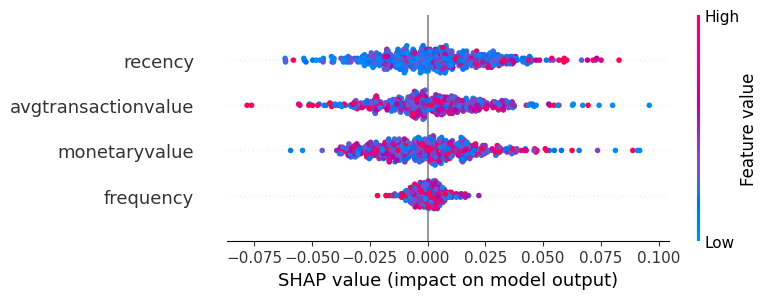

In [18]:
import shap

X_test = X_test[X_train.columns]  # Reordering columns to match X_train

explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test, check_additivity=False)

# Plotting SHAP
shap.summary_plot(shap_values, X_test)

recency and avg transaction value have the greatest impact on the prediction. A positive SHAP value indicates that the recency and avg transaction pushed the prediction higher if features are higher, while a negative value indicates that the feature pushed the prediction lower whrn features are lower. Also we can see high values in recency on th right side and low - on the left on x-axis.


So we can say that key driver of CLV is recency.

In [19]:
import pandas as pd

# Extracting SHAP values
shap_values_array = shap_values.values
feature_names = X_test.columns

shap_df = pd.DataFrame(shap_values_array, columns=feature_names, index=X_test.index)

shap_df['base_value'] = shap_values.base_values
shap_df['model_prediction'] = shap_values.base_values + shap_values_array.sum(axis=1)

shap_df.to_csv("shap_values.csv", index=True)


In [ ]:
rfm['predicted_clv'] = rf.predict(X)

In [ ]:
rfm.head()

,clientid,recency,frequency,monetaryvalue,avgtransactionvalue,recency_log,avg_transaction_log,cluster,PCA1,PCA2,cluster_label,future_revenue,predicted_clv
0,00018c3f-5f99-4f68-a78a-016985759872,0.232877,0.428571,0.490291,0.517381,5.141664,7.139851,1,0.527259,1.080279,Loyal Customers,0.197824,0.316866
1,000a5e19-8ebf-4d40-924d-d209e2526223,0.091781,0.785714,0.555160,0.339343,4.219508,6.725298,4,1.980129,0.944570,Loyal High-Value Customers,0.197824,0.265805
2,000b1f18-a74f-4e5f-9a94-d809ad51cc03,0.042466,0.214286,0.133620,0.244425,3.465736,6.405278,2,-0.678511,-1.069242,"Moderate Spend, Low Frequency",0.197824,0.257731
3,0037c351-6d1c-4390-87d9-95c7a92c87dd,0.028767,0.428571,0.389360,0.409669,3.091042,6.910043,0,0.901068,-0.580336,Loyal High-Value Customers,0.358946,0.336531
4,005e3c87-0c61-4077-8550-25ce1a71de7e,0.053425,0.714286,0.353865,0.234109,3.688879,6.363425,4,1.274894,0.079296,Loyal High-Value Customers,0.358946,0.393823


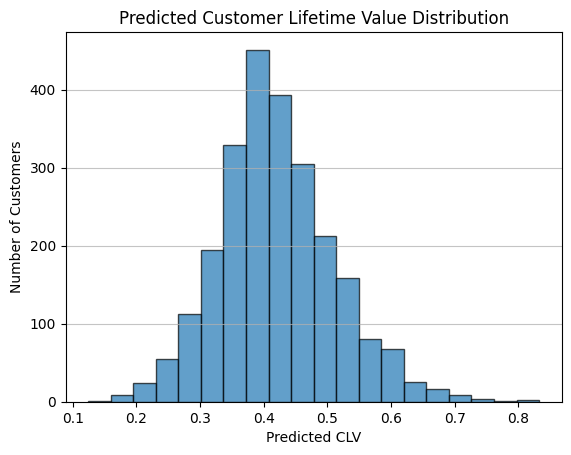

In [ ]:
import matplotlib.pyplot as plt

# Histogram of predicted CLV
plt.hist(rfm['predicted_clv'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Predicted Customer Lifetime Value Distribution')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Predicted CLV')
plt.ylabel('Number of Customers')
plt.show()